# Accelerating data analysis using cudf.pandas

In this notebook, we explore how data scientists can dramatically accelerate their analysis workflows without modifying existing code. Using the NYC ride-share dataset—containing millions of trip records with detailed information about pickup/dropoff locations, fares, and ride durations—we demonstrate the seamless integration of GPU acceleration through RAPIDS' cudf.pandas extension. By simply adding one import statement, analysts can continue using the familiar Pandas API while operations execute on NVIDIA GPUs in the background, reducing processing time from minutes to seconds.

In [1]:
%load_ext cudf.pandas

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings("ignore")

# NYC Taxi Data Analysis

This notebook analyzes taxi ride data from the NYC TLC ride share dataset. We're using this dataset stored in S3 that contains information about rides including pickup/dropoff locations, fares, trip times, and other metrics.

In the following cells, we:
1. Set up AWS credentials to access the S3 bucket containing the data
2. Create an S3 filesystem connection
3. Load and concatenate multiple Parquet files from the dataset
4. Explore the data structure and prepare for analysis

The dataset contains detailed ride information that will allow us to analyze patterns in taxi usage, pricing, and service differences between companies.


In [4]:
import boto3

# Get temporary credentials

aws_access_key_id = "*****"
aws_secret_access_key = "*****"
aws_session_token = "*****"

# Use the temporary credentials
s3 = boto3.resource(
    "s3",
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    aws_session_token=aws_session_token,
)

In [5]:
import s3fs

fs = s3fs.S3FileSystem(
    key=aws_access_key_id, secret=aws_secret_access_key, token=aws_session_token
)

In [6]:
path_files = []

for i in range(660, 720):
    path_files.append(
        pd.read_parquet(f"s3://coiled-data/uber/part.{i}.parquet", filesystem=fs)
    )

data = pd.concat(path_files, ignore_index=True)
len(data)

64811259

# Data Loading and Initial Exploration

In the previous cells, we:
1. Set up AWS credentials to access S3 storage
2. Created an S3 filesystem connection
3. Loaded and concatenated multiple Parquet files (parts 660-720) from the ride-share dataset
4. Checked the dataset size (64,811,259 records)

Now we're examining the structure of our data by:
- Viewing the first few rows with `head()`
- Inspecting column names
- Analyzing data types
- Optimizing memory usage by converting data types (int32→int16, float64→float32, string→category)

The dataset contains ride information from various ride-hailing services, which we'll map to company names (Uber, Lyft, etc.) for better analysis.


In [7]:
data.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2022-10-18 15:41:35,2022-10-18 15:48:37,2022-10-18 15:50:15,2022-10-18 16:08:27,47,78,1.390,...,1.07,0.0,0.0,0.0,11.26,N,N,<NA>,N,N
1,HV0005,B03406,<NA>,2022-10-18 15:54:39,NaT,2022-10-18 15:57:39,2022-10-18 16:07:18,130,131,1.028,...,0.70,0.0,0.0,0.0,6.33,N,N,N,N,N
2,HV0003,B03404,B03404,2022-10-18 15:01:16,2022-10-18 15:02:43,2022-10-18 15:03:17,2022-10-18 15:15:31,200,241,2.950,...,1.10,0.0,0.0,0.0,11.14,N,N,<NA>,N,N
3,HV0003,B03404,B03404,2022-10-18 15:20:45,2022-10-18 15:24:15,2022-10-18 15:24:48,2022-10-18 15:31:59,18,18,0.570,...,0.79,0.0,0.0,0.0,6.64,N,N,<NA>,N,N
4,HV0003,B03404,B03404,2022-10-18 15:29:47,2022-10-18 15:33:39,2022-10-18 15:34:24,2022-10-18 15:53:05,94,248,2.910,...,1.66,0.0,0.0,0.0,14.52,N,N,<NA>,N,N


In [8]:
data.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [9]:
data.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[us]
on_scene_datetime       datetime64[us]
pickup_datetime         datetime64[us]
dropoff_datetime        datetime64[us]
PULocationID                     int32
DOLocationID                     int32
trip_miles                     float32
trip_time                        int32
base_passenger_fare            float32
tolls                          float32
bcf                            float32
sales_tax                      float32
congestion_surcharge           float32
airport_fee                    float32
tips                           float32
driver_pay                     float32
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
dtype: object

In [10]:
for col in data.columns:
    if data[col].dtype == "int32":
        min_value = -32768
        max_value = 32767
        if data[col].min() >= min_value and data[col].max() <= max_value:
            data[col] = data[col].astype("int16")
        else:
            print(
                f"Column '{col}' cannot be safely converted to int16 due to value range."
            )
    if data[col].dtype == "float64":
        data[col] = data[col].astype("float32")
    if data[col].dtype == "string" or data[col].dtype == "object":
        data[col] = data[col].astype("category")

Column 'trip_time' cannot be safely converted to int16 due to value range.


In [11]:
data.dtypes

hvfhs_license_num             category
dispatching_base_num          category
originating_base_num          category
request_datetime        datetime64[us]
on_scene_datetime       datetime64[us]
pickup_datetime         datetime64[us]
dropoff_datetime        datetime64[us]
PULocationID                     int16
DOLocationID                     int16
trip_miles                     float32
trip_time                        int32
base_passenger_fare            float32
tolls                          float32
bcf                            float32
sales_tax                      float32
congestion_surcharge           float32
airport_fee                    float32
tips                           float32
driver_pay                     float32
shared_request_flag           category
shared_match_flag             category
access_a_ride_flag            category
wav_request_flag              category
wav_match_flag                category
dtype: object

In [12]:
# data = data.dropna()

# Create a company mapping dictionary
company_mapping = {
    "HV0002": "Juno",
    "HV0003": "Uber",
    "HV0004": "Via",
    "HV0005": "Lyft",
}

# Replace the hvfhs_license_num with company names
data["company"] = data["hvfhs_license_num"].map(company_mapping)
data.drop("hvfhs_license_num", axis=1, inplace=True)

# Data Transformation and Analysis

In the next three cells, we're performing several key data transformations and analyses:

1. **Cell 15**: We're extracting the month from the pickup datetime and creating a new column. Then we're calculating the total fare by summing various fare components. Finally, we're grouping the data by company and month to analyze trip counts, revenue, average fares, and driver payments.

2. **Cell 16**: We're calculating the profit for each company by month by subtracting the total driver payout from the total revenue.

3. **Cell 17**: We're displaying the complete grouped dataset that includes all the metrics we've calculated (trip counts, revenue, average fares, driver payouts, and profits) for each company by month.

These transformations help us understand the financial performance of different rideshare companies across different months.


In [13]:
data["pickup_month"] = data["pickup_datetime"].dt.month

data["total_fare"] = (
    data["base_passenger_fare"]
    + data["tolls"]
    + data["bcf"]
    + data["sales_tax"]
    + data["congestion_surcharge"]
    + data["airport_fee"]
)

grouped = (
    data.groupby(["company", "pickup_month"])
    .agg(
        {
            "company": "count",
            "total_fare": ["sum", "mean"],
            "driver_pay": "sum",
            "tips": "sum",
        }
    )
    .reset_index()
)

grouped.columns = [
    "company",
    "pickup_month",
    "trip_count",
    "total_revenue",
    "avg_fare",
    "total_driver_pay",
    "total_tips",
]

grouped["total_driver_payout"] = grouped["total_driver_pay"] + grouped["total_tips"]

grouped = grouped[
    [
        "company",
        "pickup_month",
        "trip_count",
        "total_revenue",
        "avg_fare",
        "total_driver_payout",
    ]
]

grouped = grouped.sort_values(["company", "pickup_month"])

grouped["profit"] = grouped["total_revenue"] - grouped["total_driver_payout"]

grouped.head()

,company,pickup_month,trip_count,total_revenue,avg_fare,total_driver_payout,profit
0,Lyft,1,4898879,121683760.0,24.839103,77961272.0,43722488.0
1,Lyft,10,2319596,64832340.0,27.949841,43752420.0,21079920.0
2,Lyft,11,5117891,136568464.0,26.684520,90697264.0,45871200.0
3,Lyft,12,5657939,150960176.0,26.681125,98486688.0,52473488.0
4,Uber,1,13580152,366343040.0,26.976358,250266704.0,116076336.0


In [14]:
grouped["profit"] = grouped["total_revenue"] - grouped["total_driver_payout"]

In [15]:
grouped

,company,pickup_month,trip_count,total_revenue,avg_fare,total_driver_payout,profit
0,Lyft,1,4898879,121683760.0,24.839103,77961272.0,43722488.0
1,Lyft,10,2319596,64832340.0,27.949841,43752420.0,21079920.0
2,Lyft,11,5117891,136568464.0,26.684520,90697264.0,45871200.0
3,Lyft,12,5657939,150960176.0,26.681125,98486688.0,52473488.0
4,Uber,1,13580152,366343040.0,26.976358,250266704.0,116076336.0
5,Uber,10,6260889,192093504.0,30.681506,134541680.0,57551824.0
6,Uber,11,12968005,388421952.0,29.952329,264810560.0,123611392.0
7,Uber,12,14007908,432905792.0,30.904386,292669184.0,140236608.0


# Trip Duration Analysis

The next three cells are performing the following operations:

1. **Cell 19**: We're defining a function called `categorize_trip` that categorizes trips based on their duration. 
   - Trips less than 10 minutes (600 seconds) are categorized as short (0)
   - Trips between 10-20 minutes (600-1200 seconds) are categorized as medium (1)
   - Trips longer than 20 minutes (1200+ seconds) are categorized as long (2)
   
   This categorization helps us analyze how trip duration affects various metrics.

   User-Defined Functions (UDFs) like the one above. perform better with numerical values as compared to strings,
   hence we are using a numerical representation of trip types.

3. **Cell 20**: We're applying the `categorize_trip` function to each row in our dataset, creating a new column 
   called 'trip_category' that contains the category value (0, 1, or 2) for each trip. This transformation 
   allows us to group and analyze trips by their duration categories.

4. **Cell 21**: We're grouping the data by trip category and calculating statistics for each group:
   - The mean and sum of total fares
   - The count of trips in each category
   
   This analysis helps us understand how trip duration relates to fare amounts and trip frequency.


In [16]:
def categorize_trip(row):
    if row["trip_time"] < 600:  # Less than 10 minutes
        return 0
    elif row["trip_time"] < 1200:  # 10-20 minutes
        return 1
    else:  # More than 20 minutes
        return 2

In [17]:
# Apply UDF
data["trip_category"] = data.apply(categorize_trip, axis=1)

In [18]:
# Create a mapping for trip categories
trip_category_map = {0: "short", 1: "medium", 2: "long"}

# Group by trip category
category_stats = data.groupby("trip_category").agg(
    {"total_fare": ["mean", "sum"], "trip_time": "count"}
)

# Rename the index with descriptive labels
category_stats.index = category_stats.index.map(lambda x: f"{trip_category_map[x]}")

category_stats

total_fare               trip_time
                    mean           sum     count
trip_category                                   
short          11.943861  1.968005e+08  16477123
medium         20.912767  5.168305e+08  24713637
long           48.276928  1.140325e+09  23620499


## Location Data Analysis

The TLC dataset has columns PULocationID and DOLocationID which indicate the zone and borough information according to the taxi zones of the New York TLC. You can download this information and look up the zones corresponding to the index in CSV format [here](https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv).

The next few cells (23-32) are focused on:

1. **Cells 23-26**: Loading and preparing taxi zone data
   - Loading taxi zone information from a CSV file
   - Examining the data structure
   - Selecting only the relevant columns (LocationID, zone, borough)

2. **Cells 27-28**: Enriching our trip data with location information
   - Merging pickup location data using PULocationID
   - Creating a combined pickup_location field
   - Merging dropoff location data using DOLocationID
   - Creating a combined dropoff_location field

3. **Cell 29**: Analyzing popular routes
   - Grouping data by pickup and dropoff locations
   - Counting rides between each location pair
   - Identifying the top 10 most frequent routes (hotspots)


In [25]:
taxi_zones = pd.read_csv("taxi_zones.csv")

In [26]:
taxi_zones.head()

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island


In [27]:
taxi_zones = taxi_zones[["LocationID", "zone", "borough"]]

In [28]:
taxi_zones

,LocationID,zone,borough
0,1,Newark Airport,EWR
1,2,Jamaica Bay,Queens
2,3,Allerton/Pelham Gardens,Bronx
3,4,Alphabet City,Manhattan
4,5,Arden Heights,Staten Island
...,...,...,...
258,256,Williamsburg (South Side),Brooklyn
259,259,Woodlawn/Wakefield,Bronx
260,260,Woodside,Queens
261,261,World Trade Center,Manhattan


In [29]:
data = pd.merge(
    data, taxi_zones, left_on="PULocationID", right_on="LocationID", how="left"
)
for col in ["zone", "borough"]:
    data[col] = data[col].fillna("NA")
data["pickup_location"] = data["zone"] + "," + data["borough"]
data.drop(["LocationID", "zone", "borough"], axis=1, inplace=True)

In [30]:
data = pd.merge(
    data, taxi_zones, left_on="DOLocationID", right_on="LocationID", how="left"
)
for col in ["zone", "borough"]:
    data[col] = data[col].fillna("NA")
data["dropoff_location"] = data["zone"] + "," + data["borough"]
data.drop(["LocationID", "zone", "borough"], axis=1, inplace=True)

In [31]:
location_group = (
    data.groupby(["pickup_location", "dropoff_location"])
    .size()
    .reset_index(name="ride_count")
)
location_group = location_group.sort_values("ride_count", ascending=False)

# Identify top 10 hotspots
top_hotspots = location_group.head(10)
print("Top 10 Pickup and Dropoff Hotspots:")
print(top_hotspots)

Top 10 Pickup and Dropoff Hotspots:
                    pickup_location              dropoff_location  ride_count
29305            JFK Airport,Queens                         NA,NA      214629
17422        East New York,Brooklyn        East New York,Brooklyn      204280
5533          Borough Park,Brooklyn         Borough Park,Brooklyn      144201
31607      LaGuardia Airport,Queens                         NA,NA      130948
8590              Canarsie,Brooklyn             Canarsie,Brooklyn      117952
13640  Crown Heights North,Brooklyn  Crown Heights North,Brooklyn       99066
1068                 Astoria,Queens                Astoria,Queens       87116
2538             Bay Ridge,Brooklyn            Bay Ridge,Brooklyn       87009
29518        Jackson Heights,Queens        Jackson Heights,Queens       85413
50620       South Ozone Park,Queens            JFK Airport,Queens       82798


In [32]:
data.drop(["pickup_month", "PULocationID", "DOLocationID"], axis=1, inplace=True)

In [33]:
data.head()

,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,trip_miles,trip_time,base_passenger_fare,tolls,...,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,company,total_fare,trip_category,pickup_location,dropoff_location
0,B03404,B03404,2022-10-18 15:41:35,2022-10-18 15:48:37,2022-10-18 15:50:15,2022-10-18 16:08:27,1.390,1092,12.02,0.0,...,N,N,NaN,N,N,Uber,13.450000,1,"Claremont/Bathgate,Bronx","East Tremont,Bronx"
1,B03406,NaN,2022-10-18 15:54:39,NaT,2022-10-18 15:57:39,2022-10-18 16:07:18,1.028,579,7.88,0.0,...,N,N,N,N,N,Lyft,8.820000,0,"Jamaica,Queens","Jamaica Estates,Queens"
2,B03404,B03404,2022-10-18 15:01:16,2022-10-18 15:02:43,2022-10-18 15:03:17,2022-10-18 15:15:31,2.950,734,12.44,0.0,...,N,N,NaN,N,N,Uber,13.910000,1,"Riverdale/North Riverdale/Fieldston,Bronx","Van Cortlandt Village,Bronx"
3,B03404,B03404,2022-10-18 15:20:45,2022-10-18 15:24:15,2022-10-18 15:24:48,2022-10-18 15:31:59,0.570,431,8.89,0.0,...,N,N,NaN,N,N,Uber,9.950001,0,"Bedford Park,Bronx","Bedford Park,Bronx"
4,B03404,B03404,2022-10-18 15:29:47,2022-10-18 15:33:39,2022-10-18 15:34:24,2022-10-18 15:53:05,2.910,1121,18.68,0.0,...,N,N,NaN,N,N,Uber,20.900000,1,"Fordham South,Bronx","West Farms/Bronx River,Bronx"


# Time-Based Analysis and Visualization

The next two cells analyze and visualize how ride patterns change throughout the day:

1. Cell 33 extracts the hour of the day from pickup timestamps and calculates the average trip time and cost for each hour. It handles missing hours by adding them with zero values, ensuring a complete 24-hour view.

2. Cell 34 displays the resulting dataframe, showing how trip duration and cost vary by hour of the day. This helps identify peak hours, pricing patterns, and potential opportunities for optimizing service.


In [34]:
# Find the volume per hour of the day and how much an average trip costs along with average trip time.

data["pickup_hour"] = data["pickup_datetime"].dt.hour
time_grouped = (
    data.groupby("pickup_hour")
    .agg({"trip_time": "mean", "total_fare": "mean"})
    .reset_index()
)
time_grouped.columns = ["pickup_hour", "mean_trip_time", "mean_trip_cost"]
hours = range(0, 24)
missing_hours = [h for h in hours if h not in time_grouped["pickup_hour"].values]
for hour in missing_hours:
    new_row = {"pickup_hour": hour, "mean_trip_time": 0.0, "mean_trip_cost": 0.0}
    time_grouped = pd.concat([time_grouped, pd.DataFrame([new_row])], ignore_index=True)
time_grouped = time_grouped.sort_values("pickup_hour")

In [35]:
time_grouped

,pickup_hour,mean_trip_time,mean_trip_cost
0,0,1010.579544,28.302725
1,1,959.207064,27.369673
2,2,945.615068,27.741272
3,3,972.436700,29.060489
4,4,1036.492632,32.784849
5,5,1093.815407,32.542842
6,6,1152.112576,31.339607
7,7,1166.739691,28.935733
8,8,1136.297709,27.066979
9,9,1119.351153,26.359760


# Time-Based Visualization

The next cell creates a time series visualization that shows how average fares change over time for different ride-hailing companies:

1. It groups the data by company and day (using pd.Grouper with freq='D')
2. Calculates the mean total fare for each company-day combination
3. Creates a line plot using seaborn's lineplot function, with:
   - Time on the x-axis
   - Average fare on the y-axis
   - Different colors for each company

This visualization helps identify trends in pricing over time and compare fare patterns between companies (Uber vs. Lyft).


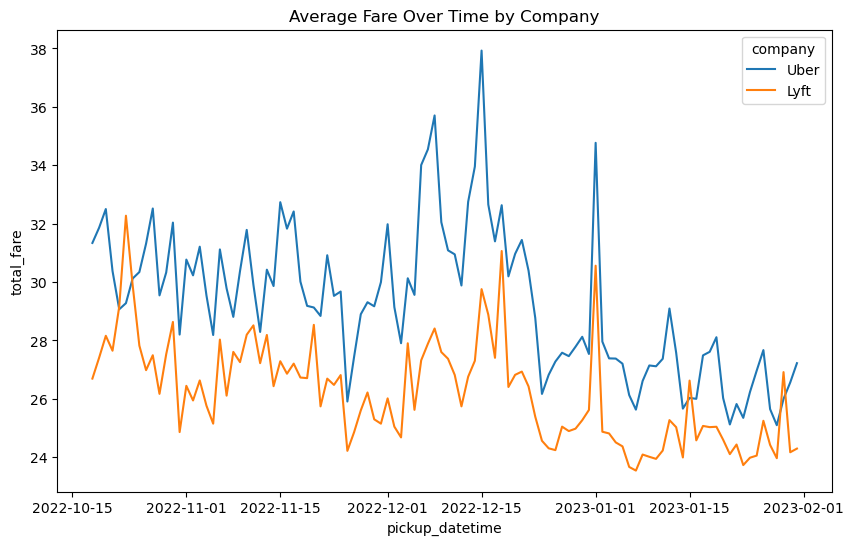

In [35]:
financial = (
    data.groupby(["company", pd.Grouper(key="pickup_datetime", freq="D")])[
        ["total_fare"]
    ]
    .mean()
    .reset_index()
)

# Example visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x="pickup_datetime", y="total_fare", hue="company", data=financial)
plt.title("Average Fare Over Time by Company")
plt.show()

# Shared Ride and Accessibility Analysis

The next cell analyzes two important service aspects of ride-hailing platforms:

1. **Shared Ride Metrics**:
   - Calculates average fare and trip time for shared vs. non-shared rides
   - Determines the acceptance rate of shared ride requests (when riders opt in but may not get matched)
   - Helps understand the economics and efficiency of ride-sharing features

2. **Wheelchair Accessibility Metrics**:
   - Analyzes average fare and trip time for wheelchair accessible vehicles (WAV)
   - Calculates the percentage of wheelchair accessible ride requests that were fulfilled
   - Provides insights into service equity and accessibility compliance

The analysis prints summary statistics for both service types and their respective acceptance rates.


In [36]:
shared_grouped = (
    data.groupby("shared_match_flag")
    .agg({"total_fare": "mean", "trip_time": "mean"})
    .reset_index()
)

shared_grouped.columns = ["shared_match_flag", "mean_fare_shared", "mean_time_shared"]

shared_request_acceptance = (
    data[data["shared_request_flag"] == "Y"]
    .groupby("shared_match_flag")["shared_request_flag"]
    .count()
    .reset_index()
)
shared_request_acceptance.columns = ["shared_match_flag", "count"]
shared_request_acceptance = shared_request_acceptance.set_index("shared_match_flag")

total_shared_requests = shared_request_acceptance.sum()

shared_acceptance_rate = (
    shared_request_acceptance["count"]["Y"] / total_shared_requests * 100
)
print(f"Shared Ride Acceptance Rate: {float(shared_acceptance_rate)}%")

wav_grouped = (
    data.groupby("wav_match_flag")
    .agg({"total_fare": "mean", "trip_time": "mean"})
    .reset_index()
)

wav_grouped.columns = ["wav_match_flag", "mean_fare_wav", "mean_time_wav"]

# 4. Calculate percentage of wheelchair accessible ride requests that were accepted
wav_request_acceptance = (
    data[data["wav_request_flag"] == "Y"]
    .groupby("wav_match_flag")["wav_request_flag"]
    .count()
    .reset_index()
)
wav_request_acceptance.columns = ["wav_match_flag", "count"]
wav_request_acceptance = wav_request_acceptance.set_index("wav_match_flag")

total_wav_requests = wav_request_acceptance.sum()

wav_acceptance_rate = wav_request_acceptance["count"]["Y"] / total_wav_requests * 100
print(f"Wheelchair Accessible Ride Acceptance Rate: {float(wav_acceptance_rate)}%")

# Display the results
print(shared_grouped)
print(wav_grouped)

Shared Ride Acceptance Rate: 33.766986535707765%
Wheelchair Accessible Ride Acceptance Rate: 99.99361674964892%
  shared_match_flag  mean_fare_shared  mean_time_shared
0                 Y         25.189627       1770.353920
1                 N         28.541140       1154.111679
  wav_match_flag  mean_fare_wav  mean_time_wav
0              Y      24.208971    1064.793459
1              N      28.819339    1166.241749


# Fare Per Mile Analysis

In the next three cells, we:

1. Define a function `fare_per_mile()` that calculates the fare per mile for each trip by dividing the total fare by the trip miles. The function includes validation to handle edge cases where trip miles or trip time might be zero.

2. Apply this function to create a new column in our dataset called 'fare_per_mile', which represents the cost efficiency of each trip.

3. Calculate and display summary statistics for fare per mile grouped by trip category, showing the mean fare per mile and count of trips for each category. This helps us understand how cost efficiency varies across different trip types.

This analysis provides insights into pricing efficiency and helps identify potential pricing anomalies across different trip categories.


In [36]:
def fare_per_mile(row):
    if row["trip_time"] > 0:
        if row["trip_miles"] > 0:
            return row["total_fare"] / row["trip_miles"]
        else:
            return 0
    return 0

In [37]:
data["fare_per_mile"] = data.apply(fare_per_mile, axis=1)

In [38]:
# Create a mapping for trip categories
trip_category_map = {0: "short", 1: "medium", 2: "long"}

# Calculate fare per mile statistics grouped by trip category
fare_per_mile_stats = data.groupby("trip_category").agg(
    {"fare_per_mile": ["mean", "count"]}
)

# Add a more descriptive index using the mapping
fare_per_mile_stats.index = fare_per_mile_stats.index.map(
    lambda x: f"{trip_category_map[x]}"
)

fare_per_mile_stats

fare_per_mile          
                       mean     count
trip_category                        
short             11.523434  16590987
medium             7.993338  24870225
long               6.310465  23707938